# Split train/test
To keep some test data unseen by gridsearch

# Import

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Pandas & ML
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier

sns.set()

# Third party
import mlflow
import shap
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from mlflow.models import infer_signature

# Pandas & ML
# from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.decomposition import NMF, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv, enable_iterative_imputer
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics._scorer import make_scorer
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from xgboost import XGBClassifier

In [2]:
# load cleaned data
df = pd.read_pickle("../data/processed/data_cleaned.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Columns: 798 entries, index to CC_COUNT
dtypes: bool(133), float64(606), int64(43), object(16)
memory usage: 1.6+ GB


In [43]:
# frac
df = df.sample(frac=0.5)

# remove inf values not supported by sklearn
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# split train / test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["TARGET", "SK_ID_CURR", "index"], axis=1), df.TARGET
)

# Baseline classifier

### Random classifier

In [44]:
random_clf = DummyClassifier(strategy="uniform")
random_clf.fit(X_train, y_train)
y_pred_random = random_clf.predict(X_test)

### Grant all loans

In [45]:
grant_all_clf = DummyClassifier(strategy="constant", constant=0)
grant_all_clf.fit(X_train, y_train)
y_pred_grant_all = grant_all_clf.predict(X_test)

### Deny all loans

In [46]:
deny_all_clf = DummyClassifier(strategy="constant", constant=1)
deny_all_clf.fit(X_train, y_train)
y_pred_deny_all = deny_all_clf.predict(X_test)

### Perfect classifier
predictions are the same as true labels

# Custom metric : Profits and Loss function

In [130]:
def human_format(num: float | int, pos=None) -> str:
    """
    Format a big number in a human readable way with dollar sign and SI prefixes (k,m,M etc)

    Parameters
    ----------
    num: float | int
        Raw number

    Returns
    -------
    str:
        Human readable number as a string
    """
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "${:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [48]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    df[df["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / df[df["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(
    y_true: "ndarray",
    y_pred: "ndarray",
    interest: "float" = 0.04,
    goods_recover_rate: "float" = 0.70,
):
    """
    Naive estimation of gains and losses for the bank
    if loans are granted according to model predictions.

    Parameters
    ----------
    y_true: ndarray
        Numpy array of true classes
    y_pred: ndarray
        Numpy array of predictions given by a model (0 or 1)
    interest: float, default 0.04
        Interest rate on credit amount the bank charges when loan is correctly repayed.
        Because this value was not provided in the dataset, we'll use current market tendencies.
    goods_recover_rate: float, default 0.60
        Rate of monetary value recovered on goods seized by the bank for customers that can't repay their loan.

    Returns
    -------
    float:
        Total sum of gains and losses for the bank
    """
    # TODO: X en param
    # df.apply(bank_revenue)
    # y_proba
    credit = df.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            df.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            df.loc[X_test.index, "AMT_GOODS_PRICE"],
            df.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    bank_revenue = pd.Series(np.nan)
    # TP: loan correctly denied = no loss, no gain
    bank_revenue = np.where((y_pred == 1) & (y_true == 1), 0, bank_revenue)
    # FP: loan incorreclty denied: loss of interest
    bank_revenue = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        bank_revenue,
    )
    # TN: loan correcly granted: gain of interest
    bank_revenue = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        bank_revenue,
    )
    # FN: loan incorrectly granted: loan amount is lost, customer goods are seized and sold
    bank_revenue = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit + seized_goods,
        bank_revenue,
    )
    return bank_revenue.sum()

In [115]:
# calculate $ revenue for random prediction
# will be used as a baseline for evaluating other models
# TODO: average over 10 runs
BASELINE_PNL = pnl(
    y_test,
    y_pred_random,
)


def pnl_to_baseline(y_true: "ndarray", y_pred: "ndarray", normalize=False):
    """
    Compare difference in revenue for the bank between predictions from a model,
    and random predictions.

    Parameters
    ----------
    y_true: ndarray
        Numpy array of true classes
    y_pred: ndarray
        Numpy array of predictions given by a model (0 or 1)
    normalize: True | False, default: False
        If False (default), returns difference in gains for the bank compared to random predictions
        Units : $
        If True, returns the difference in gains as a ratio (compared to baseline revenue)
            0: no improvement, same as random predictions
            2: 200% gain augmentation, better than baseline
            -2: 200% loss, worst than baseline

    Returns
    -------
    float | str:
        Difference in revenue for the bank
    """
    dollar_diff = pnl(y_true, y_pred) - BASELINE_PNL
    if normalize:
        return dollar_diff / abs(BASELINE_PNL)
    else:
        return dollar_diff

### Create customer scorer from custom pnl function

In [50]:
pnl_scorer = make_scorer(pnl, greater_is_better=True)

# Naive undersampler to fix target imbalance

In [51]:
# def NaiveUnderSampler(df):
#     # find the minority class
#     min_class = df.TARGET.value_counts().idxmin()
#     # keep same number of majority class than minority
#     target_minority_count = df[df.TARGET == min_class].shape[0]
#     df_balanced = pd.concat(
#         [
#             df[df.TARGET == min_class].sample(target_minority_count),
#             df[df.TARGET != min_class].sample(target_minority_count),
#         ]
#     )
#     # shuffle rows
#     return df_balanced.sample(frac=1)

In [52]:
def NaiveUnderSampler(X, y):
    # TODO: docstring
    # find the minority class
    min_class = y.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = y[y == min_class].shape[0]
    df_balanced = pd.concat(
        [
            X[y == min_class].sample(target_minority_count),
            X[y != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [53]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [54]:
# test naive imbalance fixer
# df.pipe(NaiveUnderSampler).TARGET.value_counts()

# Model Optimization

In [55]:
# local server must be running: $ mlflow ui
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("P7 ML")
# mlflow.sklearn.autolog()  # log only sklearn model, not shap etc

<Experiment: artifact_location='mlflow-artifacts:/132287291501882802', creation_time=1708695008003, experiment_id='132287291501882802', last_update_time=1708695008003, lifecycle_stage='active', name='P7 ML', tags={}>

In [56]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import TargetEncoder

In [57]:
# subset columns by dtype
num_cols = X_train.select_dtypes(include=["bool", "int64", "float64"]).columns.tolist()
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()

In [58]:
column_based_imputer = make_column_transformer(
    (SimpleImputer(strategy="median"), num_cols),
    (
        SimpleImputer(strategy="most_frequent"),
        categorical_columns,
    ),
)

# empty pipe, just a list of steps
pipe = Pipeline(
    [
        ("imputer", column_based_imputer),
        ("scaler", [RobustScaler()]),
        ("category_encoding", TargetEncoder()),
        ("reduce_dim", [VarianceThreshold()]),
        ("sampler", [RandomOverSampler()]),
        ("classifier", [LGBMClassifier()]),
    ]
)

In [59]:
# each step if selected through successive gridsearched
# options that are not optimal are commented out
param_grid = [
    {
        # "imputer": [
        #     # SimpleImputer(),
        #     # IterativeImputer(),
        #     # KNNImputer(),
        # ],
        "scaler": [
            # RobustScaler(),
            # MinMaxScaler(),
            StandardScaler(),
        ],
        "sampler": [
            RandomUnderSampler(),
            # RandomOverSampler(),
            # SMOTE(),
        ],
        "reduce_dim": [
            # VarianceThreshold(),
            # PCA(n_components=80),
            SelectKBest(),
        ],
        "reduce_dim__k": [200, 300],
        # "reduce_dim__threshold": [0.02],
        "classifier": [
            LGBMClassifier(),
            # LogisticRegression(max_iter=500),
            # RandomForestClassifier(),
            # XGBClassifier(),
        ],
        # "classifier__eta": np.linspace(0, 1, 6),
        "classifier__max_depth": [8],
        # "classifier__boosting_type": ["gbdt"],
        "classifier__colsample_bytree": [0.3],
        "classifier__learning_rate": [0.04],
        "classifier__min_child_samples": [3],
        "classifier__n_estimators": [200],
        "classifier__num_leaves": [3, 5],
    },
]
grid = HalvingGridSearchCV(
    pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring="roc_auc"
)
# use frac to keep training time reasonable
frac_idx = X_train.sample(frac=1).index
grid.fit(
    X_train.loc[frac_idx],
    y_train.loc[frac_idx],
    classifier__eval_metric="roc_auc",
    # classifier__early_stopping_round=20,
)
#
# store results
grid_results = pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")
display(grid_results.T)
# select and display best model
model = grid.best_estimator_
display(model)

# Log best model in MLFlow
with mlflow.start_run(nested=True):
    # Log the hyperparameters
    # mlflow.log_params(model.get_params())
    mlflow.log_params(param_grid[0])
    # use best model to make predictions on test
    y_pred = grid.predict(X_test)
    # Log the loss metric
    mlflow.log_metric("roc_auc_train", grid_results.iloc[0].mean_test_score)
    mlflow.log_metric("roc_auc_test", metrics.roc_auc_score(y_test, y_pred))
    # mlflow.log_metric("custom_pnl", pnl(y_pred, y_test))

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log dataset
    dataset = mlflow.data.from_pandas(X_train)
    mlflow.log_input(dataset, context="train")

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="P7_model",
        signature=signature,
    )

    # Log results from other gridsearch candidates
    for candidate in (
        grid_results[["params", "mean_fit_time", "mean_test_score"]].iloc[1:, :].values
    ):
        with mlflow.start_run(nested=True):
            mlflow.log_input(dataset, context="train")
            mlflow.log_params(candidate[0])
            mlflow.set_tag("duration", candidate[1])
            mlflow.log_metric("roc_auc_train", candidate[2])
mlflow.end_run()

[LightGBM] [Info] Number of positive: 957, number of negative: 957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14718
[LightGBM] [Info] Number of data points in the train set: 1914, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,4,5,1,3,2,0
iter,1,1,0,0,0,0
n_resources,11529,11529,3843,3843,3843,3843
mean_fit_time,2.102456,2.05556,0.947728,1.203897,1.046342,0.912058
std_fit_time,0.001935,0.031279,0.030228,0.098087,0.097069,0.031186
mean_score_time,0.453161,0.448027,0.250121,0.17981,0.207481,0.227624
std_score_time,0.005231,0.002481,0.029154,0.049345,0.010989,0.00421
param_classifier,"LGBMClassifier(colsample_bytree=0.3, learning_...","LGBMClassifier(colsample_bytree=0.3, learning_...","LGBMClassifier(colsample_bytree=0.3, learning_...","LGBMClassifier(colsample_bytree=0.3, learning_...","LGBMClassifier(colsample_bytree=0.3, learning_...","LGBMClassifier(colsample_bytree=0.3, learning_..."
param_classifier__colsample_bytree,0.3,0.3,0.3,0.3,0.3,0.3
param_classifier__learning_rate,0.04,0.04,0.04,0.04,0.04,0.04
param_classifier__max_depth,8,8,8,8,8,8


Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'F...
                                                   'CC_NAME_CONTRACT_STATUS_Signed_MAX',
                                                   'CC_NAME_CONTRACT_STATUS_nan_MIN',
                                                   'CC_NAME_CONTRACT_STATUS_nan_MAX'])])),
                ('scaler', StandardScaler()),
                ('category_encoding', TargetEncoder()),
                ('reduce_dim', SelectKBest(k=300)),
                ('sampler', RandomUnderSampler()),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.04,
                                max_depth=8, min_child_samples=3,
                                n_estimators=200, num_leaves=5))])

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem 

# Feature importances

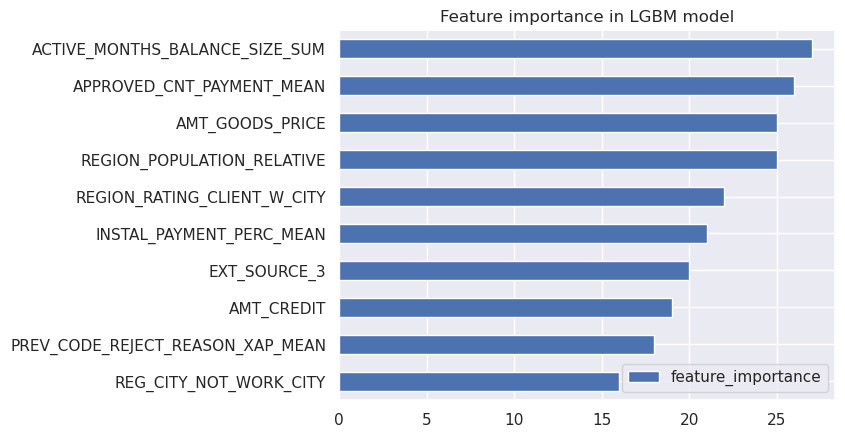

In [60]:
# get names of columns after dimension reduction
features_after_dim_reduc = X_train.columns[model["reduce_dim"].get_support()]
# Plot feature importance
pd.DataFrame(
    model["classifier"].feature_importances_,
    index=features_after_dim_reduc,
    columns=["feature_importance"],
).sort_values(by="feature_importance").tail(10).plot.barh()
plt.title("Feature importance in LGBM model")
plt.show();

# Proba predict treshold

In [134]:
model

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='median'),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'F...
                                                   'CC_NAME_CONTRACT_STATUS_Signed_MAX',
                                                   'CC_NAME_CONTRACT_STATUS_nan_MIN',
                                                   'CC_NAME_CONTRACT_STATUS_nan_MAX'])])),
                ('scaler', StandardScaler()),
                ('category_encoding', TargetEncoder()),
                ('reduce_dim', SelectKBest(k=300)),
                ('sampler', RandomUnderSampler()),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.3, learning_rate=0.04,
                                max_depth=8, min_child_samples=3,
                                n_estimators=200, num_leaves=5))])

Best threshold: 0.6842105263157894


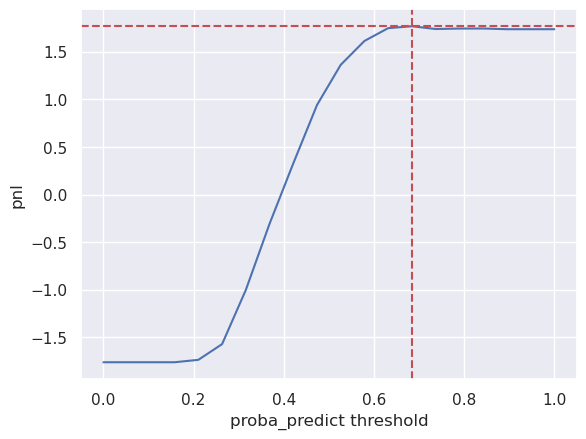

In [135]:
# looking for the proba predict threshold generating the maximum revenue
# make new predictions
y_pred_proba = (model.predict_proba(X_test))[:, 1]
res_pnl = pd.Series()
for threshold in np.linspace(0, 1, 20):
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    res_pnl.loc[threshold] = pnl_to_baseline(y_test, y_pred_threshold, normalize=True)
res_pnl.plot()
plt.xlabel("proba_predict threshold")
plt.ylabel("pnl")

# autoselect and apply best threshold
best_threshold = res_pnl.idxmax()
y_pred = (y_pred_proba >= best_threshold).astype(int)
print(f"Best threshold: {best_threshold}")
plt.axhline(y=res_pnl.max(), color="r", linestyle="--")
plt.axvline(x=res_pnl.idxmax(), color="r", linestyle="--")
plt.plot();

# Scoring metrics

## Simple metrics

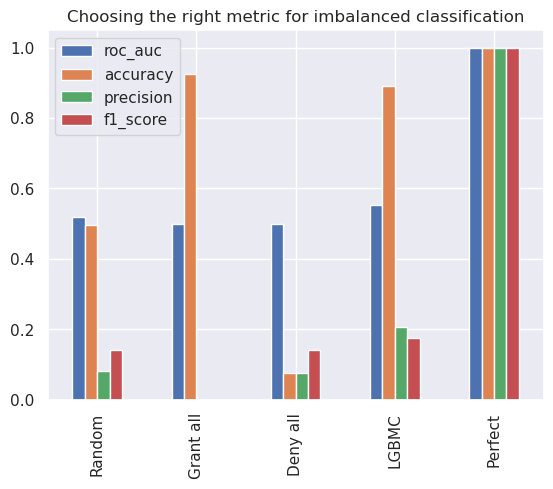

In [136]:
results = pd.DataFrame()
clf_list = ["Random", "Grant all", "Deny all", "LGBMC", "Perfect"]
pred_list = [y_pred_random, y_pred_grant_all, y_pred_deny_all, y_pred, y_test]

for name, p in zip(clf_list, pred_list):
    results.loc[name, "roc_auc"] = metrics.roc_auc_score(y_test, p)
    results.loc[name, "accuracy"] = metrics.accuracy_score(y_test, p)
    results.loc[name, "precision"] = metrics.precision_score(y_test, p, zero_division=0)
    results.loc[name, "f1_score"] = metrics.f1_score(y_test, p)
    results.loc[name, "pnl_raw"] = pnl(
        y_test,
        p,
    )
    results.loc[name, "pnl_to_baseline"] = pnl_to_baseline(y_test, p, normalize=False)

results.drop(["pnl_raw", "pnl_to_baseline"], axis=1).plot.bar(subplots=False)
plt.title("Choosing the right metric for imbalanced classification")
plt.show();

## ROC Curve

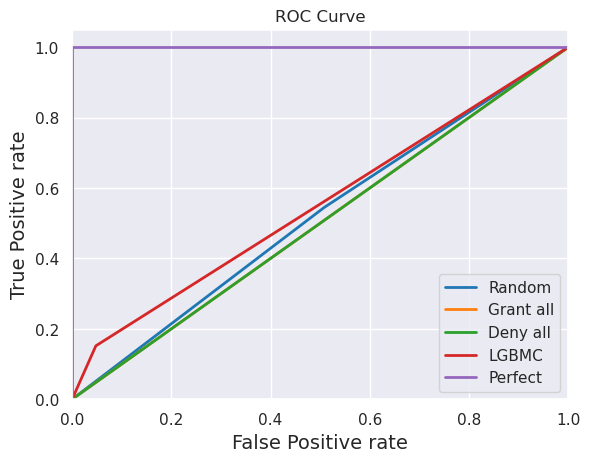

In [137]:
# ROC curve
for name, p, c in zip(clf_list, pred_list, sns.palettes.color_palette("tab10")):
    [fpr, tpr, _] = metrics.roc_curve(y_test, p)
    plt.plot(fpr, tpr, color=c, lw=2, label=name)
# ax[0].plot(fpr1, tpr1, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive rate", fontsize=14)
plt.ylabel("True Positive rate", fontsize=14)
plt.legend()
plt.title("ROC Curve")
plt.show();

## Confusion matrix

In [110]:
def custom_confusion_matrix_plot(y_pred, classes, name):
    cm = metrics.confusion_matrix(y_test, y_pred, labels=classes, normalize=None)
    disp = metrics.ConfusionMatrixDisplay(
        cm,
    )
    disp.plot()
    # use same color bar vmin and vmax values for comparing matrices
    disp.im_.set_clim(0, len(y_test))
    plt.grid()
    plt.title(f"Confusion matrix for {name} classifier")
    plt.plot();

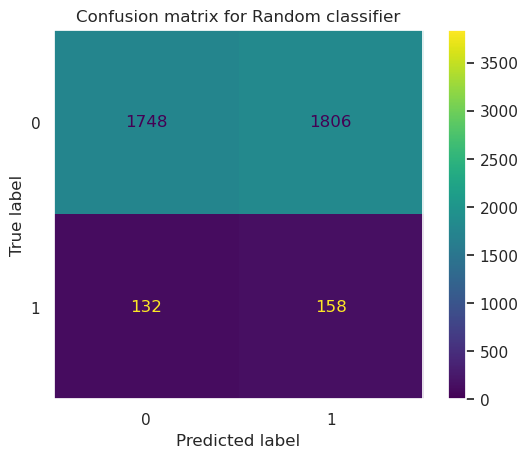

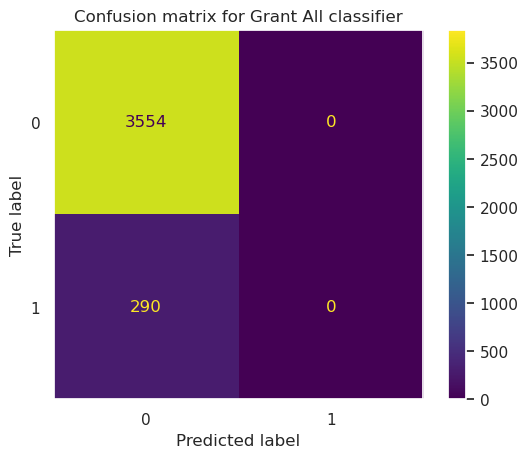

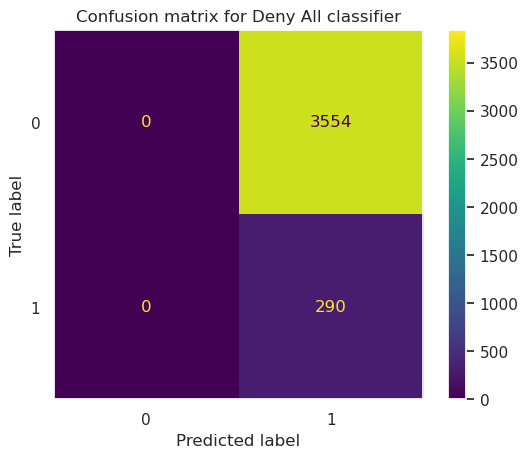

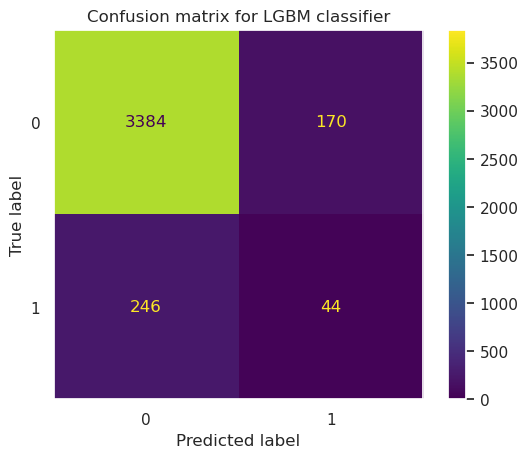

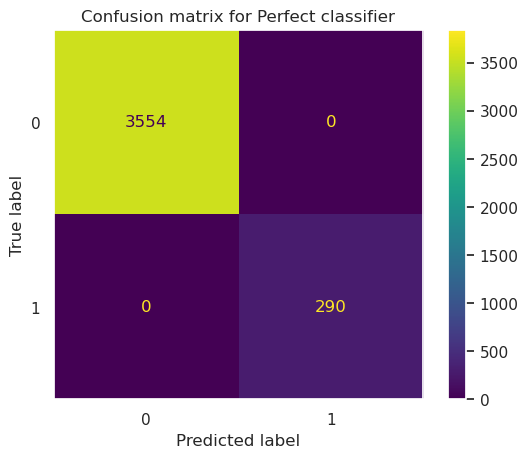

In [113]:
# Compare confusion matrices
custom_confusion_matrix_plot(y_pred_random, random_clf.classes_, "Random")
custom_confusion_matrix_plot(y_pred_grant_all, grant_all_clf.classes_, "Grant All")
custom_confusion_matrix_plot(y_pred_deny_all, deny_all_clf.classes_, "Deny All")
custom_confusion_matrix_plot(y_pred, model["classifier"].classes_, "LGBM")
custom_confusion_matrix_plot(y_test, model["classifier"].classes_, "Perfect")

## Profit and Loss metric

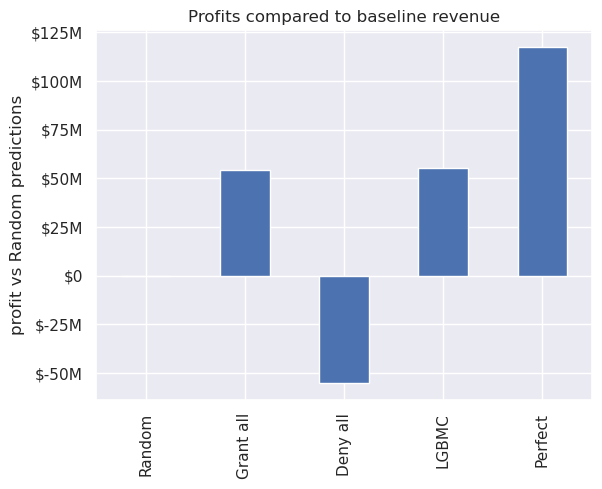

In [133]:
ax = results.pnl_to_baseline.plot.bar(subplots=False)
plt.title("Profits compared to baseline revenue")
plt.ylabel("profit vs Random predictions")
ax.yaxis.set_major_formatter(human_format)
plt.show();

# Shap values

In [ ]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

In [ ]:
X_train.sample()

In [ ]:
len(shap_values)

In [ ]:
model = grid.best_estimator_

In [ ]:
X_test.shape

In [ ]:
X_test.shape

In [ ]:
idx = X_test.sample().index[0]

In [ ]:
X_test.loc[X_test.sample().index[0], :]

In [ ]:
def shap_for_one(df, idx):
    """
    Return 10 top
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

In [ ]:
shap_dict = shap_for_one(X_test, X_test.sample().index[0])
# merge top and bottom into one dict
shap_dict["top"].update(shap_dict["bottom"])
keys = np.fromiter(shap_dict["top"].keys(), dtype=object)
values = np.fromiter(shap_dict["top"].values(), dtype=float)
shap.bar_plot(
    values,
    feature_names=keys,
    max_display=20,
)

In [ ]:
np.fromiter(shap_dict["top"].keys(), dtype=object)

In [ ]:
explainer.shap_values(X_test.sample(1))[0]

In [ ]:
# explainer for only 1 sample row
# TODO prendre que les tops
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [ ]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

In [ ]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Save trained model

In [ ]:
# Standard
import pickle

with open("../models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("../models/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

f.close()

In [ ]:
grid.best_estimator_.predict_proba(pd.DataFrame(X_test.iloc[0, :]).T)